In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.keras.utils import Sequence
print("Importou com sucesso!")


Importou com sucesso!


In [4]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10

In [5]:
# Caminhos
image_dir = '/content/drive/MyDrive/dataset Amazon Ecovision/image'
mask_dir = '/content/drive/MyDrive/dataset Amazon Ecovision/label'

# Listar arquivos de imagem (tirando extensão para facilitar)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

# Criar dataframe
df = pd.DataFrame(image_files, columns=['image_file'])

# Remover extensão .tif e salvar nome base
df['image_id'] = df['image_file'].apply(lambda x: x.replace('.tif', ''))

# Tentar encontrar máscara correspondente
def get_mask_file(image_id):
    mask_name = f"masks_{image_id}.png"
    return mask_name if mask_name in mask_files else None

df['mask_file'] = df['image_id'].apply(get_mask_file)

# Filtrar imagens que realmente têm máscara correspondente
df = df[df['mask_file'].notnull()].reset_index(drop=True)

df.head()

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: '/content/drive/MyDrive/dataset Amazon Ecovision/image'

In [ ]:
# Tamanho de imagens para teste
NUM_TEST_IMAGES = 10

# Cria um DataFrame com 10 imagens de teste aleatórias
df_test = df.sample(NUM_TEST_IMAGES, random_state=101).reset_index(drop=True)

# Cria uma lista com os caminhos das imagens de teste
test_images_list = list(df_test['image_file'])

# Filtra df para remover essas imagens, criando o DataFrame de treino
df_train = df[~df['image_file'].isin(test_images_list)].reset_index(drop=True)

# Exibe o tamanho dos dois conjuntos
print("Treino:", df_train.shape)
print("Teste:", df_test.shape)


Treino: (1113, 3)
Teste: (10, 3)


In [ ]:
from skimage.io import imread
import matplotlib.pyplot as plt

# Substitua pelo nome de um dos seus arquivos reais
sample_image = 'tiles_S2B_MSIL2A_20200202T141649_N0213_R010_T20LQN_20200202T164215-001-006.tif'
path_image = '/content/drive/MyDrive/dataset Amazon Ecovision/image/' + sample_image

# Ler e mostrar a imagem
image = imread(path_image)



Shape da imagem: (512, 512, 3)


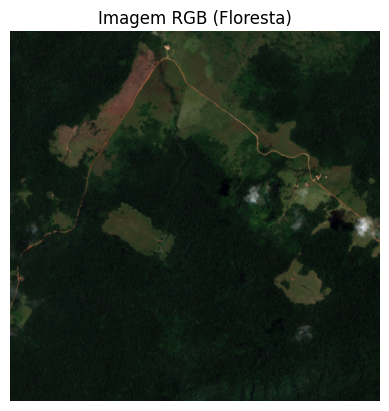

In [ ]:
print("Shape da imagem:", image.shape)  # Verifica se é 512x512x3
plt.imshow(image)
plt.title("Imagem RGB (Floresta)")
plt.axis("off")
plt.show()


Shape da máscara: (512, 512, 3)


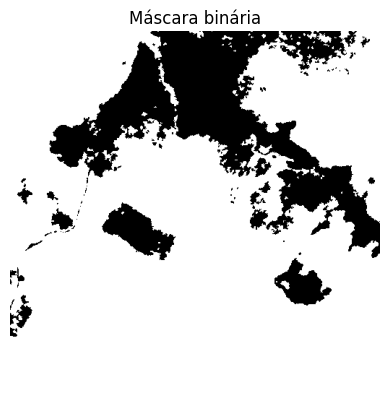

In [ ]:
from skimage.io import imread
import matplotlib.pyplot as plt

# Nome de um arquivo de máscara que combine com a imagem anterior
sample_mask = 'masks_tiles_S2B_MSIL2A_20200202T141649_N0213_R010_T20LQN_20200202T164215-001-006.png'
path_mask = '/content/drive/MyDrive/dataset Amazon Ecovision/label/' + sample_mask

# Carregar e mostrar a máscara
mask = imread(path_mask)

print("Shape da máscara:", mask.shape)
plt.imshow(mask, cmap='gray')
plt.title("Máscara binária")
plt.axis("off")
plt.show()


In [ ]:
# Get lists of images and their masks.
image_id_list = list(df['image_id'])
mask_id_list = ['masks_' + fname.replace('.tif', '.png') for fname in image_id_list]
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [ ]:
# X_train


for i, image_id in enumerate(image_id_list):

    path_image = '/content/drive/MyDrive/dataset Amazon Ecovision/image/' + image_id + '.tif'

    # read the image using skimage
    image = imread(path_image)

    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # Instead of np.expand_dims, directly assign the image data
    # to the first 3 channels of X_train
    X_train[i, :, :, :3] = image  # Assign to the first 3 channels
    # image = np.expand_dims(image, axis=-1)  # Comment out this line


    # insert the image into X_train
    # X_train[i, :, :, 0:3] = image # We make sure X_train only selects the original 3 channels to copy data into it. # Comment out this line

X_train.shape

(1123, 128, 128, 3)

In [ ]:
# Y_train


for i, mask_id in enumerate(mask_id_list):

    path_mask = '/content/drive/MyDrive/dataset Amazon Ecovision/label/' + mask_id + '.png'

    # read the image using skimage
    mask = imread(path_mask)

    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # If mask has more than one channel, select the first one
    if mask.ndim > 2:
        mask = mask[:,:,0]  # Select first channel, assuming it represents the mask

    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)

    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(1123, 128, 128, 1)

In [ ]:
# X_test

for i, image_id in enumerate(test_id_list):

    path_image = '/content/drive/MyDrive/dataset Amazon Ecovision/image/' + image_id + '.tif'

    # read the image using skimage
    image = imread(path_image)

    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # remove the use of np.expand_dims as X_test expects 3 channels
    # image = np.expand_dims(image, axis=-1)

    # insert the image into X_test, ensuring correct channel assignment
    X_test[i, :, :, :3] = image  # Assuming the image has 3 channels

X_test.shape

(10, 128, 128, 3)

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate # Import necessary layers from tensorflow.keras.layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

In [ ]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50,
                    callbacks=callbacks_list)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3960
Epoch 1: val_loss improved from inf to 0.12375, saving model to model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - loss: 0.3946 - val_loss: 0.1237
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2382
Epoch 2: val_loss improved from 0.12375 to 0.11551, saving model to model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - loss: 0.2381 - val_loss: 0.1155
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2104
Epoch 3: val_loss improved from 0.11551 to 0.10906, saving model to model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - loss: 0.2104 - val_loss: 0.1091
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2037
Epoch 4: val_loss did not improve from 0.10906
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - loss: 0.2038 - val_loss: 0.1154
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2035
Epoch 5: val_loss did not improve from 0.10906
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - loss: 0.2034 - val_loss: 0.1108
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1946
Epoch 6: val_loss improved from 0.10906 to 0.10326, saving model to model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - loss: 0.1946 - val_loss: 0.1033
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1915
Epoch 7: val_loss improved from 0.10326 to 0.09675, saving model to model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - loss: 0.1914 - val_loss: 0.0968
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1800
Epoch 8: val_loss improved from 0.09675 to 0.08773, saving model to model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - loss: 0.1800 - val_loss: 0.0877
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1700
Epoch 9: val_loss did not improve from 0.08773
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - loss: 0.1700 - val_loss: 0.0905
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1622
Epoch 10: val_loss did not improve from 0.08773
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - loss: 0.1623 - val_loss: 0.0948
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1724
Epoch 11: val_loss did not improve from 0.08773
64/64 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - loss: 0.1723 - val_loss: 0.0887
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1604
Epoch 12: val_loss did not improve from 0.08773
64/64 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - loss: 0.1604 - val_loss: 0.0881
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1777
Epoch 13: val_loss did not improve from 0.08773
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - loss: 0.1776 - val_loss: 

In [ ]:
# Make a prediction

# use the best epoch
model.load_weights('model.h5')

test_preds = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

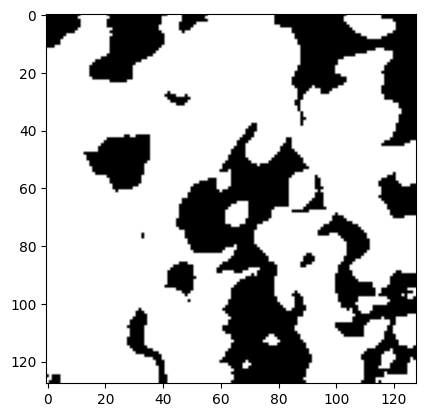

In [ ]:
# Display a thresholded mask

test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray')

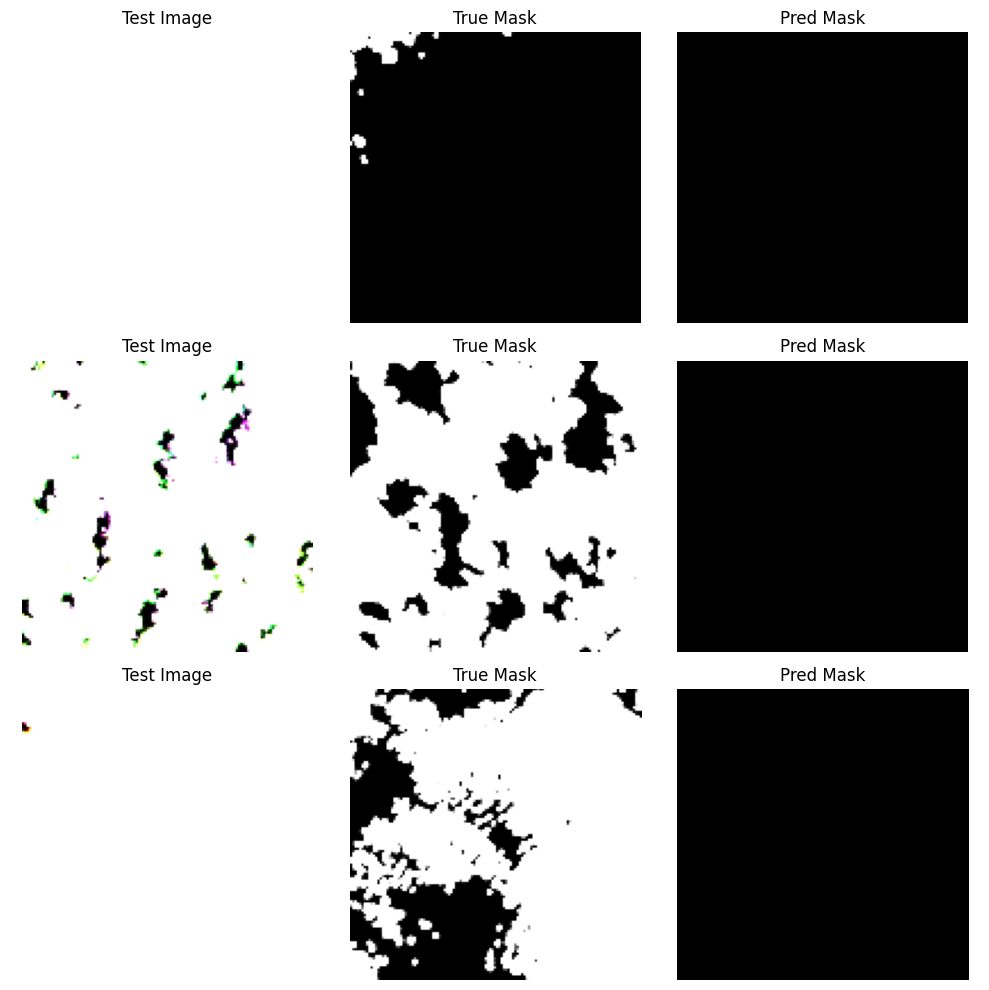

In [ ]:
# Visualização de imagens de teste, suas máscaras verdadeiras e máscaras previstas

plt.figure(figsize=(10, 10))
plt.axis('off')

# Simulação de máscaras preditas
preds_test_thresh = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1))

for i in range(9):
    if i >= len(df_test):
        break

    # imagem original
    img_path = os.path.join(image_dir, df_test.loc[i, 'image_file'])
    image = imread(img_path)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # máscara verdadeira
    mask_path = os.path.join(mask_dir, df_test.loc[i, 'mask_file'])
    mask = imread(mask_path)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # máscara predita
    pred_mask = preds_test_thresh[i, :, :, 0]

    # Plot imagem
    plt.subplot(3, 3, i * 3 % 9 + 1)
    plt.imshow(image, cmap='gray')
    plt.title('Test Image', fontsize=12)
    plt.axis('off')

    # Plot máscara verdadeira
    plt.subplot(3, 3, i * 3 % 9 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('True Mask', fontsize=12)
    plt.axis('off')

    # Plot máscara predita
    plt.subplot(3, 3, i * 3 % 9 + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Pred Mask', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()
